In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
def process_vector_df(path):
    pass

In [123]:
df = pd.read_csv('data/train_vectorized.csv', index_col=0)
df

,fname,labels,chroma_stft,mfccs_0,mfccs_1,mfccs_10,mfccs_11,mfccs_12,mfccs_13,mfccs_14,...,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,rolloff,spectral_bandwidth,spectral_centroid,zero_crossing_rate
0,ac9e7a91.wav,Church_bell,0.479215,-170.16550,167.432130,-2.061774,5.026933,-0.049025,2.770387,-5.314012,...,-14.134089,10.583515,-7.562870,2.240119,-7.175466,1.272520,2485.711033,1567.520644,1328.242650,0.069404
1,65ae847e.wav,Frying_(food),0.581880,-152.37631,-25.576666,-11.079510,-3.962794,1.837924,17.034900,0.900431,...,-14.393668,-4.354677,-12.107390,-0.230222,-10.591919,-0.697682,8190.985660,2731.856052,4837.437549,0.393471
2,32ec2454.wav,Computer_keyboard,0.594318,-430.11172,72.564810,0.556227,10.302031,6.116088,11.280382,2.382419,...,7.403701,20.482264,19.327242,14.715309,8.239096,13.407251,4712.474057,2468.614663,2206.953867,0.046988
3,af7b5bab.wav,Scissors,0.358634,-565.96500,119.060165,3.216105,7.391394,5.467248,5.948758,2.337496,...,25.366888,18.119717,11.444000,8.117064,7.384018,4.840681,1867.343387,1994.747899,1065.594477,0.025297
4,7e8cd849.wav,Purr,0.480252,-277.48990,129.397230,-9.615869,6.595200,-6.418371,5.103523,2.181881,...,-6.611706,22.031647,9.367394,2.583813,-11.835415,-6.047706,3717.121968,2311.804775,1705.573890,0.072942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4696,02a5aae7.wav,Bass_drum,0.600751,-320.23645,113.215320,10.171964,7.737941,10.406316,10.365305,5.432559,...,37.127213,39.859020,37.790577,26.058376,17.139084,13.777960,324.446917,490.027265,207.346399,0.006251
4697,9a92f7d0.wav,Bass_drum,0.590614,-365.63367,93.085890,20.914001,19.798037,15.411784,15.804122,12.606522,...,43.373490,36.439835,30.991917,28.515036,25.488148,21.751507,262.929179,888.710490,243.123495,0.006498
4698,3e5a4299.wav,"Shatter,Chink_and_clink",0.391561,-474.79300,-11.407834,-4.745295,-0.166877,0.111052,-0.588734,-4.292623,...,-5.978815,-2.473665,0.501142,-1.679157,-3.801243,-0.243563,7319.290621,2523.924622,4296.074728,0.297652
4699,4e5c0a8a.wav,Bark,0.427790,-435.88876,87.975990,0.866955,-1.378194,-1.794604,7.169077,7.157468,...,-15.378211,3.329349,4.086305,-0.667305,-15.411398,-1.761342,4714.322615,2340.827438,2287.115669,0.114685


In [122]:
df['purr'] = pd.get_dummies(df)['labels_Purr']

In [76]:
df.head()

,fname,labels,chroma_stft,mfccs_0,mfccs_1,mfccs_10,mfccs_11,mfccs_12,mfccs_13,mfccs_14,...,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,rolloff,spectral_bandwidth,spectral_centroid,zero_crossing_rate,purr
0,ac9e7a91.wav,Church_bell,0.479215,-170.16550,167.432130,-2.061774,5.026933,-0.049025,2.770387,-5.314012,...,10.583515,-7.562870,2.240119,-7.175466,1.272520,2485.711033,1567.520644,1328.242650,0.069404,0
1,65ae847e.wav,Frying_(food),0.581880,-152.37631,-25.576666,-11.079510,-3.962794,1.837924,17.034900,0.900431,...,-4.354677,-12.107390,-0.230222,-10.591919,-0.697682,8190.985660,2731.856052,4837.437549,0.393471,0
2,32ec2454.wav,Computer_keyboard,0.594318,-430.11172,72.564810,0.556227,10.302031,6.116088,11.280382,2.382419,...,20.482264,19.327242,14.715309,8.239096,13.407251,4712.474057,2468.614663,2206.953867,0.046988,0
3,af7b5bab.wav,Scissors,0.358634,-565.96500,119.060165,3.216105,7.391394,5.467248,5.948758,2.337496,...,18.119717,11.444000,8.117064,7.384018,4.840681,1867.343387,1994.747899,1065.594477,0.025297,0
4,7e8cd849.wav,Purr,0.480252,-277.48990,129.397230,-9.615869,6.595200,-6.418371,5.103523,2.181881,...,22.031647,9.367394,2.583813,-11.835415,-6.047706,3717.121968,2311.804775,1705.573890,0.072942,1


In [77]:
y = df['purr'].values

In [78]:
X = df.drop(columns=['labels', 'fname', 'purr'])
X.head()

,chroma_stft,mfccs_0,mfccs_1,mfccs_10,mfccs_11,mfccs_12,mfccs_13,mfccs_14,mfccs_15,mfccs_16,...,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,rolloff,spectral_bandwidth,spectral_centroid,zero_crossing_rate
0,0.479215,-170.16550,167.432130,-2.061774,5.026933,-0.049025,2.770387,-5.314012,-1.279660,-5.056097,...,-14.134089,10.583515,-7.562870,2.240119,-7.175466,1.272520,2485.711033,1567.520644,1328.242650,0.069404
1,0.581880,-152.37631,-25.576666,-11.079510,-3.962794,1.837924,17.034900,0.900431,-4.194548,-15.471757,...,-14.393668,-4.354677,-12.107390,-0.230222,-10.591919,-0.697682,8190.985660,2731.856052,4837.437549,0.393471
2,0.594318,-430.11172,72.564810,0.556227,10.302031,6.116088,11.280382,2.382419,8.818457,3.780853,...,7.403701,20.482264,19.327242,14.715309,8.239096,13.407251,4712.474057,2468.614663,2206.953867,0.046988
3,0.358634,-565.96500,119.060165,3.216105,7.391394,5.467248,5.948758,2.337496,7.763258,6.292786,...,25.366888,18.119717,11.444000,8.117064,7.384018,4.840681,1867.343387,1994.747899,1065.594477,0.025297
4,0.480252,-277.48990,129.397230,-9.615869,6.595200,-6.418371,5.103523,2.181881,-10.508094,4.471611,...,-6.611706,22.031647,9.367394,2.583813,-11.835415,-6.047706,3717.121968,2311.804775,1705.573890,0.072942


In [79]:
mfcc_cols = [col for col in df.columns if 'mfcc' in col]
X = df[mfcc_cols]
X.head()

,mfccs_0,mfccs_1,mfccs_10,mfccs_11,mfccs_12,mfccs_13,mfccs_14,mfccs_15,mfccs_16,mfccs_17,mfccs_18,mfccs_19,mfccs_2,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9
0,-170.16550,167.432130,-2.061774,5.026933,-0.049025,2.770387,-5.314012,-1.279660,-5.056097,-1.948983,-6.019260,-4.298630,-23.678709,12.000628,-14.134089,10.583515,-7.562870,2.240119,-7.175466,1.272520
1,-152.37631,-25.576666,-11.079510,-3.962794,1.837924,17.034900,0.900431,-4.194548,-15.471757,-4.778490,-4.762511,4.042096,-39.928910,-3.386590,-14.393668,-4.354677,-12.107390,-0.230222,-10.591919,-0.697682
2,-430.11172,72.564810,0.556227,10.302031,6.116088,11.280382,2.382419,8.818457,3.780853,6.430060,6.247881,6.210037,0.152407,34.508446,7.403701,20.482264,19.327242,14.715309,8.239096,13.407251
3,-565.96500,119.060165,3.216105,7.391394,5.467248,5.948758,2.337496,7.763258,6.292786,8.008763,3.908570,7.384831,44.468800,41.266975,25.366888,18.119717,11.444000,8.117064,7.384018,4.840681
4,-277.48990,129.397230,-9.615869,6.595200,-6.418371,5.103523,2.181881,-10.508094,4.471611,3.558397,-5.224392,-0.659105,21.469280,6.561297,-6.611706,22.031647,9.367394,2.583813,-11.835415,-6.047706


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [81]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [82]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [100]:
y_preds = gbc.predict(X_test)

In [99]:
y_probs = gbc.predict_proba(X_test)

In [114]:
acc = accuracy_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

In [106]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:,1])

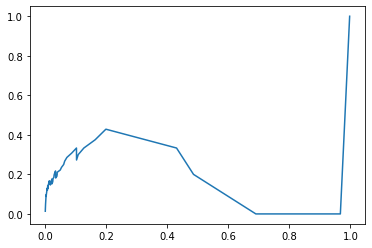

In [113]:
fig, ax = plt.subplots()

plt.plot(thresholds, precision[1:])

In [115]:
test_df = pd.read_csv('data/test_vectorized.csv')